## Mushroom Pokédex Project
Author: Alexander Mars
24/03/2021

This project has a few goals/milestones: 
1. Predict mushrooms species (hundreds to thousands) from their image using a CNN. 
2. Apply robust methods to handle label noise, and the class imbalance problem. 
2. Design and build an architecture to allow for new species to be added without retraining the entire model.
3. Use location, date, and weather data to predict when and where certain mushroom species can be foraged. 

For this project, I have kindly been given access to the mushroomobserver.org database (thank you Jason!), which contains over 1 million images of various fungi along with the time, and location of where each mushroom was foraged. Note that the database does not consist solely of mushrooms but may contain slimes, molds, and microscopic features of fungi. 

This database has been built from user-uploaded images that are generally collected whilst foraging. A user who uploads a photo or record of a mushroom creates an 'observation' on the mushroomobserver. At the time of upload a user can postulate what species they think the mushroom is. Over time each observation will have an associated vote of confidence (floating point number from 0-3) which is created by other users voting on what species they think the given observation is. 

If these models are successful, I will then attempt to combine this data with data from the Global Historical Climate Network (GHCN), maintained by the National Oceanic and Atmospheric Administration. The GHCN contains daily historical weather data from over 180 weather stations around the globe. With the GHCN, I will be able to get weather data for the local area where a particular mushroom was observed, for an arbitrary period of time leading up to the observation. I will need to conduct some research to determine what timeframe of weather data to consider. 

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import os, math, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import csv
sns.set_theme(style='darkgrid')
sns.set(font_scale = 1.4)


### Loading the Data

In [ ]:
# Load the data and see what features are present
datapath = Path('data')
datapath
names = pd.read_csv(datapath/'names.csv')
obs = pd.read_csv(datapath/'observations.csv')
images = pd.read_csv(datapath/'images_observations.csv')
locations = pd.read_csv(datapath/'locations.csv')

ParserError: Error tokenizing data. C error: Expected 4 fields in line 4, saw 5


In [ ]:
# Error parsing the locations file, let's have a look at it manually in Python
with open(datapath/'locations.csv', 'r') as f:
    for i, line in enumerate(f):
        print(line)
        if i == 100:
            break

id	name	north	south	east	west	high	low

1	Albion, Mendocino Co., California, USA	39.2408	39.2153	-123.738	-123.778	100	0

2	Burbank, California, USA	34.22	34.15	-118.29	-118.37	294	148

3	Mitrula Marsh, Tahoe National Forest, Sierra Co., California, USA	39.6272	39.6226	-120.614	-120.62	NULL	NULL

4	Salt Point State Park, Sonoma Co., California, USA	38.5923	38.5584	-123.283	-123.343	100	0

5	Gualala, Mendocino Co., California, USA	38.7868	38.7597	-123.519	-123.557	100	0

6	Elgin Co., Ontario, Canada	42.876	42.4701	-80.8044	-81.8179	NULL	NULL

7	Brett Woods, Fairfield Co., Connecticut, USA	41.2125	41.1939	-73.3215	-73.3295	NULL	NULL

8	Point Reyes National Seashore, Marin Co., California, USA	38.2441	37.9255	-122.709	-123.026	NULL	NULL

9	Howarth Park, Santa Rosa, California, USA	38.4582	38.4496	-122.663	-122.671	NULL	NULL

11	Petaluma, Sonoma Co., California, USA	38.2788	38.2055	-122.581	-122.677	NULL	NULL

12	Buttonwood, south Key Largo, Monroe Co., Florida, USA	25.0667	25.0576	-80.472

### Preliminary Data Cleanup

So the locations file looks like it contains the kind of information we want, but it will be difficult to parse with a built in parser as there is a mixture of commas and spaces used, i.e. there is no defined delimiter. It looks like we want to take everything between the first number (id) and the second number (north latitude) as the 'name' field or 'address'. The rest of the fields we can split on the space ' ' char, we could actually split each line and then join the values in the list between the first and second number as the address. Let's try that:


In [ ]:
addresses = []
others = []
with open(datapath/'locations.csv', 'r') as f:
    for line in f:
        line = line.strip().split()
        address = []
        other = []
        for val in line:
            try:
                float(val)
                other.append(val)
            except:
                if val != 'NULL':
                    address.append(val)
                else:
                    other.append('N')
        addresses.append('-'.join(address))
        # I noticed later that there are sometimes postcode values included in the
        # address information, resulting in a set of numeric values of length 8 or 9
        # I will remove these post code values as there are only a handful of 
        # addresses which contain them
        # these appear after the id and before the latitude data
        # (index 1 if length is 8, indices 1 and 2 if length is 9)
        if len(other) == 8:
            #o = [other[i] for i in range(len(other)) if i != 1]
            del other[1]
            others.append('_'.join(other))
        elif len(other) == 9:
            #o = [other[i] for i in range(len(other)) if i != 1 or i != 2]
            del other[1:3]
            others.append('_'.join(other))
        else:
            others.append('_'.join(other))

addresses = addresses[1:]
others = others[1:]

In [ ]:
# Sanity Check
len(addresses) == len(others)

True

In [ ]:
# We now have all address values properly
addresses[0:5]

['Albion,-Mendocino-Co.,-California,-USA',
 'Burbank,-California,-USA',
 'Mitrula-Marsh,-Tahoe-National-Forest,-Sierra-Co.,-California,-USA',
 'Salt-Point-State-Park,-Sonoma-Co.,-California,-USA',
 'Gualala,-Mendocino-Co.,-California,-USA']

In [ ]:
# We now have all other values in this format
# id_north_south_east_west_high_low
others[0:5]

['1_39.2408_39.2153_-123.738_-123.778_100_0',
 '2_34.22_34.15_-118.29_-118.37_294_148',
 '3_39.6272_39.6226_-120.614_-120.62_N_N',
 '4_38.5923_38.5584_-123.283_-123.343_100_0',
 '5_38.7868_38.7597_-123.519_-123.557_100_0']

Now we can create a dict from these values to then store in a pandas dataframe

In [ ]:
data = {'id': [], 'north': [], 'south':[], 'east': [], 'west': [], 'high': [], 'low': []}
for o in others:
    id, north, south, east, west, high, low = o.split('_')
    data['id'].append(id)
    data['north'].append(north)
    data['south'].append(south)
    data['east'].append(east)
    data['west'].append(west)
    data['high'].append(high)
    data['low'].append(low)


In [ ]:
addresses = [a.replace('-', ' ') for a in addresses]

In [ ]:
data['address'] = addresses

In [ ]:
locations = pd.DataFrame.from_dict(data)

In [ ]:
# Now our locations dataframe looks correct
locations.head()

,id,north,south,east,west,high,low,address
0,1,39.2408,39.2153,-123.738,-123.778,100,0,"Albion, Mendocino Co., California, USA"
1,2,34.22,34.15,-118.29,-118.37,294,148,"Burbank, California, USA"
2,3,39.6272,39.6226,-120.614,-120.62,N,N,"Mitrula Marsh, Tahoe National Forest, Sierra C..."
3,4,38.5923,38.5584,-123.283,-123.343,100,0,"Salt Point State Park, Sonoma Co., California,..."
4,5,38.7868,38.7597,-123.519,-123.557,100,0,"Gualala, Mendocino Co., California, USA"


In [ ]:
# We will now change the 'N' to NaN values as recognised by Numpy and Pandas
locations = locations.replace('N', np.NaN)

In [ ]:
# Let's save the locations dataframe as a csv, 
# we'll use '_' as a separator as addresses contain ','
locations.to_csv(datapath/'locations_clean.csv', sep='_', index = False)

In [ ]:
locations_clean = pd.read_csv(datapath/'locations_clean.csv', sep='_')
locations_clean.head()

,id,north,south,east,west,high,low,address
0,1,39.2408,39.2153,-123.738,-123.778,100.0,0.0,"Albion, Mendocino Co., California, USA"
1,2,34.2200,34.1500,-118.290,-118.370,294.0,148.0,"Burbank, California, USA"
2,3,39.6272,39.6226,-120.614,-120.620,NaN,NaN,"Mitrula Marsh, Tahoe National Forest, Sierra C..."
3,4,38.5923,38.5584,-123.283,-123.343,100.0,0.0,"Salt Point State Park, Sonoma Co., California,..."
4,5,38.7868,38.7597,-123.519,-123.557,100.0,0.0,"Gualala, Mendocino Co., California, USA"


In [ ]:
names.head()

,id,text_name,deprecated,correct_spelling_id,synonym_id,rank
0,1,Fungi,0,NaN,9274.0,14
1,2,Xylaria polymorpha group,0,NaN,8975.0,16
2,3,Xylaria magnoliae,0,NaN,NaN,4
3,4,Xylaria hypoxylon group,0,NaN,3692.0,16
4,5,Xeromphalina,0,NaN,6577.0,9


In [ ]:
obs.head()

,id,name_id,when,location_id,lat,long,alt,vote_cache,is_collection_location
0,1,2,13/7/04,214.0,NaN,NaN,NaN,1.92335,1
1,2,3,17/7/04,53.0,NaN,NaN,NaN,2.70604,1
2,3,4,8/1/02,60.0,NaN,NaN,NaN,2.49991,1
3,4,4,15/1/96,5.0,NaN,NaN,NaN,2.49991,1
4,5,5,28/12/02,36.0,NaN,NaN,NaN,1.66661,1


In [ ]:
images.head()

,image_id,observation_id
0,1,1
1,2,2
2,3,3
3,4,4
4,5,5


### Exploratory Data Analysis

I have the following initial questions for this data:


1.   What is the distribution of confidence across observations? 
2.   What is the taxonomic distribution of observations?
3.   What is the relationship between confidence and taxonomic distribution?
4.   Which species has been observed most frequently?
5.   What is the distribution of images across species?



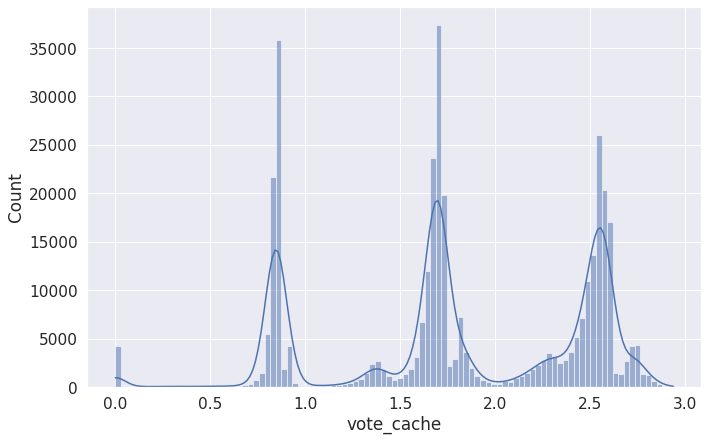

In [ ]:
# 1 Distribution of Confidence across observations
analysis = datapath / Path('analysis')
analysis.mkdir(exist_ok=True)
plt.rcParams['figure.figsize'] = (11,7)
sns.histplot(data=obs[obs.vote_cache >= 0], x="vote_cache", kde=True)
plt.savefig(analysis/'vote_distribution.png', bbox_inches = 'tight')

We appear to have a trimodal distribution with centers just below 1, 2, and approximately 2.5. Let's now work out what proportion of the data lies beyond a certain confidence threshold. 

In [ ]:
thresholds = [i*0.25 for i in range(0, 13)] 
total = len(obs.vote_cache)
t = 'Threshold'
to = 'Observations'
p = 'Proportion'
with open(datapath/'analysis/vote_obs_proportion.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow([t, to, p])
    print(f'{t:<10} {to:<12} {p}')
    for t in thresholds:
        writer.writerow([t, len(obs[obs.vote_cache >= t]), len(obs[obs.vote_cache >= t])/total*100])
        print(f'{t:<10} {len(obs[obs.vote_cache >= t]):<12} {len(obs[obs.vote_cache >= t])/total*100:.2f} %')

Threshold  Observations Proportion
0.0        364251       98.52 %
0.25       359685       97.29 %
0.5        359130       97.14 %
0.75       357632       96.73 %
1.0        286356       77.45 %
1.25       284526       76.96 %
1.5        272289       73.65 %
1.75       164854       44.59 %
2.0        145513       39.36 %
2.25       135254       36.58 %
2.5        95187        25.75 %
2.75       5316         1.44 %
3.0        0            0.00 %


So we have a tradeoff between the quantity and quality of the data that will be fed into the model. Note that the confidence rating relates specifically to whether a mushroom uploaded to the database is a certain species or not. This is important when we want to make a prediction about the species of a mushroom as we need high-confidence observations to serve as the 'ground truths' in the training data. 

We can also see that there are some observations whose confidence is below 0 or NaN, these will be removed when we later choose a confidence cutoff e.g. >= 2, so they can be ignored. 

In [ ]:
# Let's get a dictionary counting the number of observations per rank
keys = sorted(names['rank'].unique())
d = dict.fromkeys(keys, 0)
ranks = []
for n_id in obs.name_id:
    r = int(names[names.id==n_id]['rank'].values)
    ranks.append(r)
    d[r] += 1

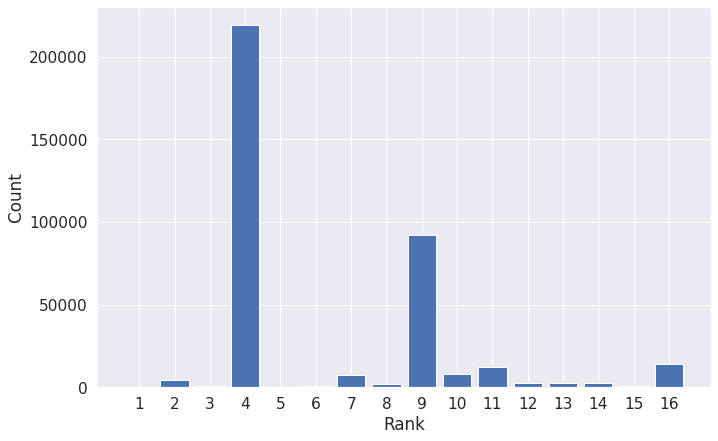

In [ ]:
plt.rcParams['figure.figsize'] = (11,7)
ind = np.arange(len(d))
plt.bar(ind, list(d.values()))
plt.xticks(ind, list(d.keys()))
plt.xlabel('Rank')
plt.ylabel('Count')
plt.savefig(datapath/'analysis/rank_distribution.png', bbox_inches = 'tight')
plt.show()

The plot shows a spike at the species level (rank 4) and the genus level (rank 9). We can choose at which level to try and make predictions. 

In [ ]:
# Adding the ranks data to the observations frame for ease of use
obs['rank']= ranks

In [ ]:
obs.head()

,id,name_id,when,location_id,lat,long,alt,vote_cache,is_collection_location,rank
0,1,2,13/7/04,214.0,NaN,NaN,NaN,1.92335,1,16
1,2,3,17/7/04,53.0,NaN,NaN,NaN,2.70604,1,4
2,3,4,8/1/02,60.0,NaN,NaN,NaN,2.49991,1,16
3,4,4,15/1/96,5.0,NaN,NaN,NaN,2.49991,1,16
4,5,5,28/12/02,36.0,NaN,NaN,NaN,1.66661,1,9


In [ ]:
obs.to_csv(datapath/'obs_withrank.csv', index=False)

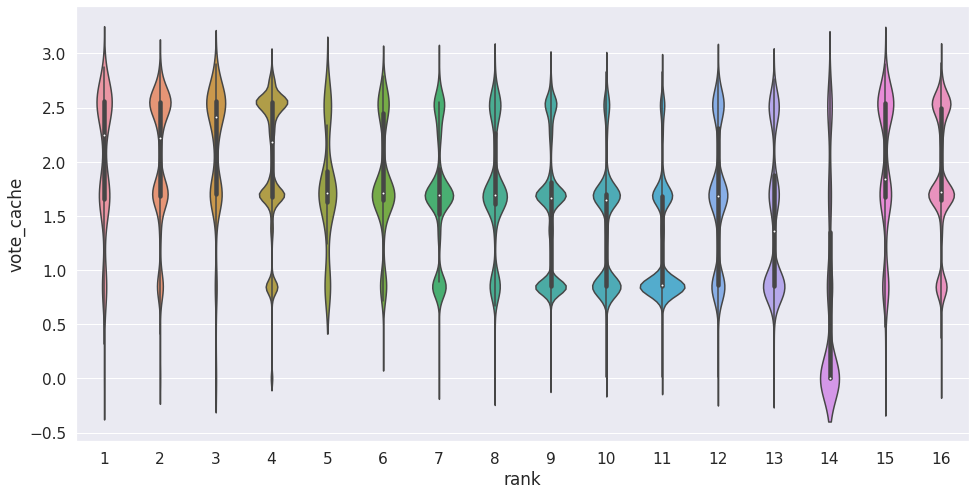

In [ ]:
# We can plot a distribution of the confidence for each rank
plt.rcParams['figure.figsize'] = (16,8)
sns.violinplot(data=obs[obs.vote_cache>=0], x='rank', y='vote_cache', inner='box')
plt.savefig(datapath/'analysis/rank_vote_distribution.png', bbox_inches = 'tight')

At this point, only observations with a confidence greater than 2, and a taxonomic rank of 1-4 were kept (confident subspecies to species level). 

In [ ]:
confident_obs = obs[obs["vote_cache"] >= 2.0]

In [ ]:
confident_obs.head(5)

,id,name_id,when,location_id,lat,long,alt,vote_cache,is_collection_location,rank
1,2,3,17/7/04,53.0,NaN,NaN,NaN,2.70604,1,4
2,3,4,8/1/02,60.0,NaN,NaN,NaN,2.49991,1,16
3,4,4,15/1/96,5.0,NaN,NaN,NaN,2.49991,1,16
5,6,61758,8/1/02,58.0,NaN,NaN,NaN,2.50528,1,16
6,7,6,7/1/05,58.0,NaN,NaN,NaN,2.49991,0,4


In [ ]:
confident_obs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145513 entries, 1 to 369709
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      145513 non-null  int64  
 1   name_id                 145513 non-null  int64  
 2   when                    145513 non-null  object 
 3   location_id             145506 non-null  float64
 4   lat                     22028 non-null   float64
 5   long                    22028 non-null   float64
 6   alt                     20638 non-null   float64
 7   vote_cache              145513 non-null  float64
 8   is_collection_location  145513 non-null  int64  
 9   rank                    145513 non-null  int64  
dtypes: float64(5), int64(4), object(1)
memory usage: 12.2+ MB


By keeping only observations whose confidence vote is greater than 2.0, we threw out 60% of all the observations on mushroom observer!

In [ ]:
confident_names = names[names["id"].isin(list(confident_obs["name_id"]))]
confident_names.head(5)

,id,text_name,deprecated,correct_spelling_id,synonym_id,rank
0,1,Fungi,0,NaN,9274.0,14
1,2,Xylaria polymorpha group,0,NaN,8975.0,16
2,3,Xylaria magnoliae,0,NaN,NaN,4
3,4,Xylaria hypoxylon group,0,NaN,3692.0,16
4,5,Xeromphalina,0,NaN,6577.0,9


The 'name_id' in the obs data corresponds to the 'id' in the names data. Thus mulitple observations may be linked to a given name. Moreover, some names may have a synonym, meaning two mushrooms which are actually the same thing have been uploaded under a different name. Changes to the scientific name of an organism over time is fairly common.

I need to first know whether a 'name_id' has a 'synonym_id' and if so, collect all the names for a given synonym, and then total up the number of observations for each name. This will give a true representation of how many observations there are for a given organism. From there I can sort to find the most frequently observed organisms. 

Additionally, notice the rank column, this relates to the scientific ranking of each name. A rank of 4 is species level, and below are subspecies. A rank of 9 is genus level, between 4 and 9 are sub-genus yet above-species. 
A simple approach is to only take ranks of 4 and below, and group ranks 1-3 under their parent at rank 4. This will eliminate confusion in classification of sub-genus variants. 


In [ ]:
species = confident_names[confident_names["rank"] <= 4]
species.head(5)

,id,text_name,deprecated,correct_spelling_id,synonym_id,rank
2,3,Xylaria magnoliae,0,NaN,NaN,4
5,6,Xerocomus zelleri,1,NaN,505.0,4
6,7,Xerocomus subtomentosus,0,NaN,645.0,4
8,9,Xerocomus chrysenteron,1,NaN,504.0,4
11,12,Verpa bohemica,0,NaN,2545.0,4


In [ ]:
species.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10422 entries, 2 to 104807
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   10422 non-null  int64  
 1   text_name            10422 non-null  object 
 2   deprecated           10422 non-null  int64  
 3   correct_spelling_id  115 non-null    float64
 4   synonym_id           4673 non-null   float64
 5   rank                 10422 non-null  int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 570.0+ KB


In [ ]:
species_obs = confident_obs[confident_obs["name_id"].isin(list(species["id"]))]

In [ ]:
species_obs.head(5)

,id,name_id,when,location_id,lat,long,alt,vote_cache,is_collection_location,rank
1,2,3,17/7/04,53.0,NaN,NaN,NaN,2.70604,1,4
6,7,6,7/1/05,58.0,NaN,NaN,NaN,2.49991,0,4
7,8,6,26/11/04,39.0,NaN,NaN,NaN,2.45144,1,4
8,9,7,3/1/03,69.0,NaN,NaN,NaN,2.49991,1,4
9,10,43604,5/1/02,38.0,NaN,NaN,NaN,2.32101,1,4


In [ ]:
species_obs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114072 entries, 1 to 369709
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      114072 non-null  int64  
 1   name_id                 114072 non-null  int64  
 2   when                    114072 non-null  object 
 3   location_id             114068 non-null  float64
 4   lat                     16946 non-null   float64
 5   long                    16946 non-null   float64
 6   alt                     15490 non-null   float64
 7   vote_cache              114072 non-null  float64
 8   is_collection_location  114072 non-null  int64  
 9   rank                    114072 non-null  int64  
dtypes: float64(5), int64(4), object(1)
memory usage: 9.6+ MB


At this point I have a species dataframe which is the names dataframe with ranks 1-4, and only linked to observations with a vote score of 2.0 or more. Likewise the species_obs dataframe contains only observations with vote greater than 2.0, and that are linked to a name_id with a rank of 1-4 (species).

Now I need to group all sub-species and synonymous species under a single identifier. This will allow me to count the total number of observations for a given organism.

An efficient way of achieving this without overwriting the 'name_id' that an observation is linked to, is to create an additional id which will be called 'taxon_id'. For a given observation this will simply be the 'synonym_id' prefixed with an 's' that is linked to the 'name_id' of that observation if available. If the the associated name does not have any synonyms it will be the 'name_id' prefixed with an 'n'.

This will tie all observations from synonymous species together under a single 'taxon_id', and if a subspecies shares the same 'synonym_id' as its parent, this will also tie in observations from that sub-species as they will all have the same 'taxon_id'. 

In [ ]:
taxon_ids = []
# For every observation
for name_id in list(species_obs["name_id"]):
    # Get the associated row for that name_id
    row = species[species['id']==name_id]
    # If no synonym, use n + 'name_id'
    if row['synonym_id'].isnull().values.any() == True:
        taxon_ids.append('n' + str(name_id))
    # If synonym, use s + 'synonym_id'
    elif row['synonym_id'].isnull().values.any() == False:
        taxon_ids.append('s' + str(row.iloc[0]['synonym_id']))           
        

In [ ]:
len(taxon_ids)

114072

In [ ]:
species_obs.insert(2, "taxon_id", taxon_ids, True)

In [ ]:
species_obs.head(10)

,id,name_id,taxon_id,when,location_id,lat,long,alt,vote_cache,is_collection_location,rank
1,2,3,n3,17/7/04,53.0,NaN,NaN,NaN,2.70604,1,4
6,7,6,s505.0,7/1/05,58.0,NaN,NaN,NaN,2.49991,0,4
7,8,6,s505.0,26/11/04,39.0,NaN,NaN,NaN,2.45144,1,4
8,9,7,s645.0,3/1/03,69.0,NaN,NaN,NaN,2.49991,1,4
9,10,43604,s4404.0,5/1/02,38.0,NaN,NaN,NaN,2.32101,1,4
10,11,43604,s4404.0,15/2/96,38.0,NaN,NaN,NaN,2.32101,1,4
12,13,25700,s593.0,7/1/05,58.0,NaN,NaN,NaN,2.75106,0,4
19,20,16,s2663.0,26/11/04,39.0,NaN,NaN,NaN,2.73580,1,4
23,24,5510,n5510,15/8/96,215.0,NaN,NaN,NaN,2.34786,1,4
28,29,30816,s6094.0,14/7/04,53.0,NaN,NaN,NaN,2.70464,1,4


In [ ]:
species[species['synonym_id']==505.0]

,id,text_name,deprecated,correct_spelling_id,synonym_id,rank
5,6,Xerocomus zelleri,1,NaN,505.0,4
613,654,Boletus zelleri,1,NaN,505.0,4
29819,31695,Xerocomellus zelleri,0,NaN,505.0,4
38851,40863,Boletus zelleri,1,NaN,505.0,4


In [ ]:
species_obs[species_obs['name_id']==654].head(5)

,id,name_id,taxon_id,when,location_id,lat,long,alt,vote_cache,is_collection_location,rank
5765,5950,654,s505.0,7/1/08,75.0,NaN,NaN,NaN,2.32669,1,4
8618,8972,654,s505.0,16/10/05,298.0,NaN,NaN,NaN,2.42038,0,4
13978,14620,654,s505.0,25/11/08,5977.0,NaN,NaN,NaN,2.02533,1,4
14010,14652,654,s505.0,27/11/08,327.0,NaN,NaN,NaN,2.54292,1,4
14306,14981,654,s505.0,6/12/08,12838.0,NaN,NaN,NaN,2.80685,1,4


Ok so that appears to have worked. Every observation is now linked to a taxon_id. Synonymous obs all have the same taxon_id too. 

However, there may be cases where a subspecies does not have a 'synonym_id' or the 'synonym_id' is different to its parent species, yet I would still like to bring these underneath one taxon_id. In this case I can fall back on the fact that the first two words of any sub-species rank (1-3) are the species rank (4). So having created taxon_id's for every observation, I can go back and check if there are any observations linked to names of rank 1-3 that have a parent of rank 4 (by using the first two words of the subspecies ranks) AND whose taxon_id is different to the rank 4 parent. Then I can simply change the taxon_id of the subspecies to the taxon_id of the rank 4 parent. 

So let's look at some sub-species:

In [ ]:
children = species[species['rank']==3].reset_index(drop=True)
children.head(5)


,id,text_name,deprecated,correct_spelling_id,synonym_id,rank
0,5066,Amanita muscaria subsp. flavivolvata,0,NaN,4383.0,3
1,6563,Cladonia gracilis subsp. turbinata,0,NaN,NaN,3
2,6596,Lecidea atrobrunnea subsp. atrobrunnea,0,NaN,NaN,3
3,6903,Alectoria sarmentosa subsp. vexillifera,0,NaN,755.0,3
4,7494,Bacidia laurocerasi subsp. idahoensis,0,NaN,886.0,3


Looking at the first child, an amanita muscaria subspecies, we see it has the synonym id 4383.0.

Now let's get all the parents for amanita muscaria subspecies:

In [ ]:
amanita_parents = species[species.text_name=='Amanita muscaria']
amanita_parents

,id,text_name,deprecated,correct_spelling_id,synonym_id,rank
352,373,Amanita muscaria,0,NaN,8935.0,4
26856,28495,Amanita muscaria,1,NaN,4383.0,4


We can see that there are two parents, but one of them has been deprecated, and they have different synonym ids. 

When we look at the obs for the amanita muscaria subspecies we can see it has the taxon_id of the deprecated parent. This is wrong, I would actually like all subspecies taxon_ids to be tied to a non-deprecated parent if possible. 

In [ ]:
amanita_parents[amanita_parents.deprecated==0].shape[0]

1

In [ ]:
species_obs[species_obs['name_id']==5066].head(5)

,id,name_id,taxon_id,when,location_id,lat,long,alt,vote_cache,is_collection_location,rank
511,514,5066,s4383.0,6/12/03,4186.0,NaN,NaN,NaN,2.89020,1,3
512,515,5066,s4383.0,5/12/03,4186.0,NaN,NaN,NaN,2.55923,1,3
513,516,5066,s4383.0,15/12/94,1861.0,NaN,NaN,NaN,2.76781,1,3
747,762,5066,s4383.0,12/11/04,12838.0,NaN,NaN,NaN,2.62415,1,3
1339,1386,5066,s4383.0,10/12/06,12838.0,NaN,NaN,NaN,2.45929,1,3


Let's look at another subspecies' parents:

In [ ]:
Cladonia_parents = species[species.text_name=='Cladonia gracilis']
Cladonia_parents

,id,text_name,deprecated,correct_spelling_id,synonym_id,rank
6212,6562,Cladonia gracilis,0,NaN,NaN,4


In [ ]:
len(Cladonia_parents[Cladonia_parents.deprecated==0])

1

In this case neither the parent or the subspecies have a synonym_id, and their name_ids are different. So the taxon_ids that their observations are linked to will also be different:


In [ ]:
cladonia_child = species_obs[species_obs['name_id']==6563]
cladonia_child.head()

,id,name_id,taxon_id,when,location_id,lat,long,alt,vote_cache,is_collection_location,rank
19704,21734,6563,n6563,31/5/09,85.0,NaN,NaN,NaN,2.57605,1,3
37437,49943,6563,n6563,21/6/09,1165.0,NaN,NaN,NaN,2.58129,1,3
83408,101256,6563,n6563,9/7/11,5695.0,44.3380,-103.968,1670.0,2.58938,1,3
83470,101318,6563,n6563,11/7/11,5698.0,47.6370,-108.673,760.0,2.58943,1,3
83606,101455,6563,n6563,13/7/11,4842.0,48.1799,-109.646,1415.0,2.58953,1,3


In [ ]:
cladonia_parent = species_obs[species_obs['name_id']==6562]
cladonia_parent.head()

,id,name_id,taxon_id,when,location_id,lat,long,alt,vote_cache,is_collection_location,rank
359364,395726,6562,n6562,20/7/19,21813.0,61.0191,-135.2256,759.0,2.18098,1,4


Ok so we have the following problems to deal with:

* We have subspecies whose observations are linked to a taxon_id that is different to 'their parent'
* We need to specify 'their parent' to be the correct parent
* I define the correct parent as:
* 1. If there is only 1 parent, it is this parent.
* 2. If there is more than parent, then it is the parent that is not deprecated i.e. deprecated = 0
* 3. If there is more than one parent with deprecated = 0 or if there is more than one parent but they are all deprecated, then it is the parent with the most observations tied to its name in either case. 
* We then need to change all the observations linked to the subspecies such that their taxon_ids match the chosen parent's taxon_id
* We also need to change all the observations linked to the non-chosen parent(s) such that their taxon_ids match the taxon_id of the chosen parent
* Finally this must be completed for all subspecies levels (1-3)

This will tie every observation to a single entity under a taxon_id. Then I can tally up the most common taxon_ids based on number of observations tied to them. This way I can be sure that I am not under counting anything in the database. 

The following definitions create an algorithm that resolves the above problems.

Given a species dataframe, and an observations dataframe, a starting parent rank (4 for species), and a starting child rank (3 or 1 level below parent rank), it outputs a new observations dataframe where all subspecies from levels 1 to 3 have had thier observation's taxon_ids changed to match a chosen level 4 parent. 

The algorithm is recursive, first redirecting all rank 3s to rank 4 parents, then rank 2s to rank 4 parents, then rank 1s to rank 4s. Then the parent rank is set to 3 and the process repeated, until the parent rank is 1 or the child rank is 0. Note that because the rank 4 parent is chosen correctly, all the rank 3's taxon_ids will be the same as the chosen rank 4 parent. This means it does not matter which rank 3 parent is chosen in subsequent runs, because the taxon_id of any rank 3 parent will already have been changed to the correct rank 4 parents. This is true EXCEPT when there are no rank 4 parents...then the rank 3 parent needs to be chosen correctly...and so forth for lower ranks. 

In [ ]:
# Dataframe Row -> String
# Extracts the first two words from 'text_name'
def get_species_names(row):
    return ' '.join((row['text_name']).split()[:2])

# 3 Dataframes: Parents, Children, and Observations, Integer (index) -> Observations Dataframe
# Checks whether a child has the same taxon id as the parent, if not, makes it the same
def check_taxon_ids(children, parents, observations, index):
    
    # Reset index to match the order of species names
    children = children.reset_index(drop=True)
    
    # Is subspecies's taxon_id the same as the parent? (SUB-PARENT-TAXON-CHECK)
    if ((str(children.iloc[index]['synonym_id']) == str(parents.iloc[0]['synonym_id'])) \
    & (str(children.iloc[index]['synonym_id']) != 'nan'))\
    or str(children.iloc[index]['id']) == str(parents.iloc[0]['id']):
        # if it is then do nothing
        return
        # Otherwise change the taxon_id of all the child observations to be the same as the parent's
    else:
        parent_taxon_id = str(observations[observations['name_id']==parents.iloc[0]['id']].iloc[0]['taxon_id'])
        observations.loc[observations['name_id']==children.loc[index,'id'], 'taxon_id'] = parent_taxon_id

# 3 Dataframes: ChosenParent, OtherParents and Observations -> Observation Dataframe
# Make all Obs linked to OtherParents have the same taxon ID as ChosenParent
def assimilate_parents(chosen_parent, parents, observations):
    
    # Get taxon_id of chosen_parent
    parent_taxon_id = str(observations[observations['name_id']==chosen_parent.iloc[0]['id']].iloc[0]['taxon_id'])
    # Set taxon_id of other parents to this value
    for parent_name_id in list(parents['id']):
        observations.loc[observations['name_id']==parent_name_id, 'taxon_id'] = parent_taxon_id

# 2 Dataframes: Parents and Observations -> taxon_id
# Find the parent with the most observations tied to its name, return the taxon_id of this parent
def get_most_observed(parents, observations):
    tally = {}
    for parent in list(parents['id']):
        tally[parent] = len(observations[observations['name_id']==parent].index)
        return int(max(tally, key=tally.get))
            
# parent-rank = 4, child-rank = 3 initially
def assimilate_taxon_ids(species_df, species_obs_df, parent_rank, child_rank):

    # Once all ranks have been assimilated, return the new observations dataframe
    # This is the base case required to end recursion.
    if child_rank == 0:
        return species_obs_df
    
    # Get df of rank 'child-rank' in species_df
    children = species_df[species_df['rank']==child_rank]
    # Extract all species names from this df
    species_names = children.apply(get_species_names, axis=1).reset_index(drop=True)
    
    # For a given child 
    for i, child in enumerate(list(species_names)):
        parents = species_df[(species_df['rank']==parent_rank) & (species_df['text_name']==child)]
        
        # Check if there is at least one rank of 'parent-rank' of the same species
        if not parents.empty:                
            
            # if there is only one parent
            # or there is more than one rank 'parent-rank' parent but they all have same taxon id (that is not nan)
            # I am trusting the database that if all parents have nan for syn_id, they will have different name_ids
            if len(parents.index) == 1 \
            or (parents['synonym_id'].nunique(dropna=False) == 1 \
                & (str(parents.iloc[0]['synonym_id']) != 'nan')):
                
                # Run through SUB-PARENT-TAXON-CHECK
                check_taxon_ids(children, parents, species_obs_df, i)
            
            # if there are rank 'parent-rank' parents with different taxon_ids 
            # len(parents.index) > 1 & parents['synonym_id'].nunique(dropna=False) > 1:
            else: 
                
                # If only one deprecated = 0
                if len(parents[parents.deprecated==0]) == 1:
                    # Choose this as parent and run through SUB-PARENT-TAXON-CHECK
                    parent = parents[parents['deprecated']==0]
                    
                    check_taxon_ids(children, parent, species_obs_df, i)
                    
                    # Also change all other parent's taxon_ids to be the same as the chosen parent
                    assimilate_parents(parent, parents, species_obs_df)
                    
                # else if more than one deprecated = 0: 
                elif len(parents[parents.deprecated==0]) > 1:
                    # Check which has more observations tied to its name_id (PARENT-OBS-CHECK)
                    ok_parents = parents[parents['deprecated']==0]
                    most_observed_id = get_most_observed(ok_parents, species_obs_df)
                                                            
                    # Choose most observed as parent and run through SUB-PARENT-TAXON-CHECK
                    parent = ok_parents[ok_parents['id']==most_observed_id]                  
                    check_taxon_ids(children, parent, species_obs_df, i)              
                    
                    # Also change all other parent's taxon id's to be the same as chosen parent
                    assimilate_parents(parent, parents, species_obs_df)
                    
                else:
                    # There are only parents with deprecated = 1 flag
                    # Check which has more observations tied to its name_id (PARENT-OBS-CHECK)
                    most_observed_id = get_most_observed(parents, species_obs_df)
                                        
                    # Choose most observed as parent and run through SUB-PARENT-TAXON-CHECK
                    parent = parents[parents['id']==most_observed_id]
                                        
                    check_taxon_ids(children, parent, species_obs_df, i)              
                    
                    # Also change all other parent's taxon id's to be the same as chosen parent
                    assimilate_parents(parent, parents, species_obs_df)
    
    # Run the function again now assimilating the next rank
    # i.e. Map 3 to 4, 2 to 4, 1 to 4, then 2 to 3, 1 to 3, 2 to 1, then break at 1 to 0 (see top of fn)
    if child_rank == 1:
        assimilate_taxon_ids(species_df, species_obs_df, parent_rank-1, parent_rank-2)
    else:
        assimilate_taxon_ids(species_df, species_obs_df, parent_rank, child_rank-1)

In [ ]:
species_cp = species
obs_copy = species_obs
obs_copy[obs_copy['name_id']==5066].head(5)

,id,name_id,taxon_id,when,location_id,lat,long,alt,vote_cache,is_collection_location,rank
511,514,5066,s4383.0,6/12/03,4186.0,NaN,NaN,NaN,2.89020,1,3
512,515,5066,s4383.0,5/12/03,4186.0,NaN,NaN,NaN,2.55923,1,3
513,516,5066,s4383.0,15/12/94,1861.0,NaN,NaN,NaN,2.76781,1,3
747,762,5066,s4383.0,12/11/04,12838.0,NaN,NaN,NaN,2.62415,1,3
1339,1386,5066,s4383.0,10/12/06,12838.0,NaN,NaN,NaN,2.45929,1,3


In [ ]:
obs_copy = assimilate_taxon_ids(species_cp, obs_copy, 4, 3)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [ ]:
species_obs[species_obs['name_id']==5066].head(5)

,id,name_id,taxon_id,when,location_id,lat,long,alt,vote_cache,is_collection_location,rank
511,514,5066,s8935.0,6/12/03,4186.0,NaN,NaN,NaN,2.89020,1,3
512,515,5066,s8935.0,5/12/03,4186.0,NaN,NaN,NaN,2.55923,1,3
513,516,5066,s8935.0,15/12/94,1861.0,NaN,NaN,NaN,2.76781,1,3
747,762,5066,s8935.0,12/11/04,12838.0,NaN,NaN,NaN,2.62415,1,3
1339,1386,5066,s8935.0,10/12/06,12838.0,NaN,NaN,NaN,2.45929,1,3


In [ ]:
species_obs[species_obs['name_id']==6563].head(5)

,id,name_id,taxon_id,when,location_id,lat,long,alt,vote_cache,is_collection_location,rank
19704,21734,6563,n6562,31/5/09,85.0,NaN,NaN,NaN,2.57605,1,3
37437,49943,6563,n6562,21/6/09,1165.0,NaN,NaN,NaN,2.58129,1,3
83408,101256,6563,n6562,9/7/11,5695.0,44.3380,-103.968,1670.0,2.58938,1,3
83470,101318,6563,n6562,11/7/11,5698.0,47.6370,-108.673,760.0,2.58943,1,3
83606,101455,6563,n6562,13/7/11,4842.0,48.1799,-109.646,1415.0,2.58953,1,3


Ok so that has worked. For a given mushroom, all observations are tied to a single taxon_id. I'm now saving these dataframes as CSVs from which I can train different models.

In [ ]:
species.to_csv(datapath/'species_conf2_taxons1-4.csv')
species_obs.to_csv(datapath/'obs_conf2_taxons1-4.csv')

## So now I have filitered the data and can build some models
## Go to 2-mush-obs-images for the notebook where image data is downloaded from the Mushroomobserver.org api